In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm import tqdm

import math

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [3]:
batch_size = 128
torch.manual_seed(50)

In [4]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists('results'):
    os.mkdir('results')

kwargs = {'num_workers': 1, 'pin_memory': True} if device.type == "cuda:0" else {}
trainset = datasets.MNIST(root='./data', train=True,
                          download=True, transform=transforms.ToTensor())
train_loader = DataLoader(trainset, batch_size=batch_size,
                          shuffle=True, **kwargs)

testset = datasets.MNIST(root='./data', train=False,
                          download=True, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=batch_size,
                         shuffle=False, **kwargs)

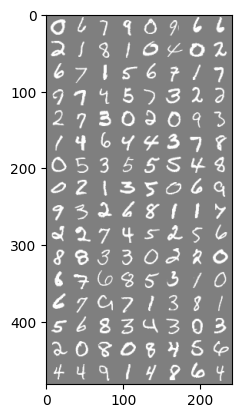

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

In [7]:
# encoder layer. Takes x as input and encodes it to latent space
class LadderEncoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.in_dim = dims[0]
        self.out_dim = dims[1]
        self.z_dim = dims[2]
        
        self.linear = nn.Linear(self.in_dim, self.out_dim)
        self.batchnorm = nn.BatchNorm1d(self.out_dim)
        
        self.mu = nn.Linear(self.out_dim, self.z_dim)
        self.log_var = nn.Linear(self.out_dim, self.z_dim)
        
    def forward(self, x):
        # hidden
        x = self.linear(x)
        x = F.leaky_relu(self.batchnorm(x), 0.1)
        
        # latent
        mu = self.mu(x)
        log_var = F.softplus(self.log_var(x))
        
        # repam
        eps = torch.randn_like(log_var).to(device)
        std = torch.exp(0.5 * log_var)
        z = mu + eps * std
        
        
        return x, z, mu, log_var


# decoder layer. Takes z as input and decoes it to x
class LadderDecoder(nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.in_dim = dims[0]
        self.out_dim = dims[1]
        self.z_dim = dims[2]
        
        self.linear1 = nn.Linear(self.z_dim, self.out_dim)
        self.batchnrom1 = nn.BatchNorm1d(self.out_dim)
        
        self.mu = nn.Linear(self.out_dim, self.in_dim)
        self.log_var = nn.Linear(self.out_dim, self.in_dim)
        
        ########
        
        self.linear2 = nn.Linear(self.z_dim, self.out_dim)
        self.batchnrom2 = nn.BatchNorm1d(self.out_dim)
        
        self.mu2 = nn.Linear(self.out_dim, self.in_dim)
        self.log_var2 = nn.Linear(self.out_dim, self.z_dim)
        
    
    def forward(self, x, mu1=None, log_var1=None):
        # if we have a mu and log_var we then sample from this layer
        if mu1 is not None:
            # sample from encoder layer and merge
            z = self.linear1(x)
            z = F.leaky_relu(self.batchnrom1(z), 0.1)
            
            mu2 = self.mu(z)
            log_var2 = F.softplus(self.log_var(z))
            precision1, precision2 = (1/torch.exp(log_var1), 1/torch.exp(log_var2))
            
            # merged mu and log_var
            q_mu = ((mu1 * precision1) + (mu2 * precision2)) / (precision1 + precision2)
            var = 1 / (precision1 + precision2)
            q_log_var = torch.log(var + 1e-8)
            
            # repam
            eps = torch.randn_like(q_log_var).to(device)
            std = torch.exp(0.5 * q_log_var)
            q_z = q_mu + eps * std
            
        # sample from decoder and send forward
        z = self.linear2(x)
        z = F.leaky_relu(self.batchnrom2(z), 0.1)
        p_mu = self.mu2(z)
        p_log_var = F.softplus(self.log_var2(z))
        
        # repam
        eps = torch.randn_like(p_log_var).to(device)
        std = torch.exp(0.5 * p_log_var)
        z = p_mu + eps * std
        
        
        if mu1 is None:
            return z
        
        return z, (q_z, (q_mu, q_log_var), (p_mu, p_log_var))

In [10]:
class LadderVAE(nn.Module):
    def __init__(self, data_dim, hidden_dims, latent_dims):
        super().__init__()
        self.data_dim = data_dim
        self.hidden_dims = hidden_dims
        self.latent_dims = latent_dims
        
        
        